In [5]:
import numpy as np
import pandas as pd
import math

In [6]:
df=pd.read_csv("TD1.csv", sep=";")
df["Cours de Natixis"] = df["Cours de Natixis"].astype(str).str.replace(",", ".").astype(float)

In [7]:
df.head()

,Date,Cours de Natixis
0,02/01/2015,5.621
1,05/01/2015,5.424
2,06/01/2015,5.329
3,07/01/2015,5.224
4,08/01/2015,5.453


In [8]:
df.tail()

,Date,Cours de Natixis
1018,21/12/2018,4.045
1019,24/12/2018,4.010
1020,27/12/2018,3.938
1021,28/12/2018,4.088
1022,31/12/2018,4.119


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              1023 non-null   object 
 1   Cours de Natixis  1023 non-null   float64
dtypes: float64(1), object(1)
memory usage: 16.1+ KB


In [10]:
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)


## Question A ##

In [12]:
P = df["Cours de Natixis"].values 
returns = (P[1:] - P[:-1]) / P[:-1]        #we calculate the daily returns using current price and previous price
returns = np.append(returns, np.nan)

df["Return"] = returns

df_date = df[(df["Date"] >= "2015-01-01") & (df["Date"] <= "2016-12-31")]    #we take only the data returns between january 2015 and december 2016

df_sorted = df_date.sort_values(by = "Return", ascending = True)    #we sort the returns in increasing order

df_sorted.head()



,Date,Cours de Natixis,Return
377,2016-06-23,4.150,-0.171325
344,2016-05-09,4.386,-0.069083
357,2016-05-26,4.752,-0.061448
404,2016-08-01,3.643,-0.060664
276,2016-02-01,4.470,-0.058613


In [13]:
alpha = 0.05  # probability level here we choosed 5%, just need to change it here to change it for other VaR

### Historical VaR ###

In [15]:
returns = df_sorted["Return"]

returns_sorted=np.sort(returns)
n=len(returns_sorted)

# Find the index corresponding to the value of alpha. With a length n then the index is n*alpha. And so it will give the 95th percentile smallest value
index_empirical = int(alpha * (n-1))   #we take n-1 and not n because indexes start at 0

# Empirical VaR
VaR_empirical = returns_sorted[index_empirical]

print(f"Empirical VaR at {alpha*100}%: {VaR_empirical:}")

Empirical VaR at 5.0%: -0.038933559035124875


### Biweight VaR ###

In [17]:
# we first start with calculating the bandwidth, first we start by finding the standard deviation
expectation = sum(returns)/n
expecation_square=sum(returns**2)/n
std=(expecation_square- expectation*expectation)**(1/2)

h=((4*(std**5))/(3*n))**(1/5)

print("the calculated bandwidth is : ", h)

# now next step is to create a list of values that will be the potential VaR selected
#so we create 10000 points going from minimum return to maximum returns and in those number will be the VaR we select using the Kernel method
x_search = np.linspace(returns.min(), returns.max(), 10000)

cdf = []

for x in x_search :
    #we know that in the kernel formula u = (x - Xi) / h
    #so let's calculate u
    u=(x-returns.values)/h
    
    #we start by putting only 0s in the kernel array. Then the values will change if u is between -1 and 1 or sup 1 and stay at 0 if u inf -1.
    kernel=np.zeros_like(u)
    #in the function we are given that the indicatrice is for |x|<1 (so x>= -1 and and x <= 1 (here x is u)
    #first condition -1 <= u <= 1
    indicatrice= (u>=-1)&(u<=1)
    #so we consider only the value of x that are contained in that interval
    val= u[indicatrice]

    #now let's calculate the integral of K
    # (1-x²)² = 1 - 2x² + x**4
    #  Integral from - 1 to u (-1 because of the indicatrice and u because we calculate the cdf of K(u)
    # so we can decompose in integral from -1 to 0 + integral from 0 to u. And since it is a cdf of a symetric function around 0 then integral from -1 to 0 = 0.5
    # so integral from 0 to u is equal to u - 2/3 u**3 +1/5 u**5
    kernel[indicatrice] = 0.5 + (15/16) * (val - (2/3)*val**3 + (1/5)*val**5)

    #second condition u >1 then the cdf of K will be the integral on all the density function since it will be from -1 to u with indicatrice 
    #saying that u<1 so it become from - 1 to 1 and so the integral on all the density is equal to 1 by definition
    kernel[u > 1] = 1.0
    #now we take the average of the differente values of the kernel (1/n sum(kernel))
    estimation = sum(kernel)/len(kernel)
    cdf.append(estimation)
    
#we convert it to an array so we can substract alpha to each values of the cdf we calculated
cdf = np.array(cdf)
#we find the best argument
idx_var = np.argmin(np.abs(cdf - alpha))
#and finally we use this argument to find which value generated was the best kernel VaR
VaR_kernel = x_search[idx_var]

print("Biweight Kernel VaR at alpha : ", alpha," VaR_kernel = ", VaR_kernel)

the calculated bandwidth is :  0.007250001157290293
Biweight Kernel VaR at alpha :  0.05  VaR_kernel =  -0.03811674623640021


### b) Porportion of returns that exceeded between January 2017 and December 2018 ###

In [19]:
df_newdate=df[ (df["Date"]<="2018-12-31") & (df["Date"] >= "2017-01-01")]  #we make a new dataset with this time the returns 
#between January 2017 and December 2018

In [20]:
#so we sort it again
df_sorted2=df_newdate.sort_values(by = "Return", ascending=True) 
returns2=df_sorted2["Return"]    
returns2=returns2.dropna()
returns2_sorted=np.sort(returns2)

In [21]:
exceptions = returns2<=VaR_kernel   #we check for the values that are below the Kernel VaR calculated
n_exceptions=sum(exceptions)    #we count the how many there was
proportion=n_exceptions/len(returns2_sorted)          #we divided by the number of total returns in the time desired
print("number of days : ",len(returns2_sorted))
print("exceptions : ", n_exceptions)
print("the proportion that exceeded the VaR of the Kernel", proportion)

number of days :  509
exceptions :  8
the proportion that exceeded the VaR of the Kernel 0.015717092337917484


A proportion of 0.0157 mean that 1.57% of the values were below the value. This means that  in the following years (january 2017 to december 2018) the natixis stocks had less spikes in the losses, since we compared with the 5% worst case considering January 2015 to December 2016. We can note that the market for natixis was less volatil and risky in 2017/2018.
The probability we aimed to get was 5% hence we didn't get the result we expected as 1.57% is pretty far from 5%. The model overestimate the risk. It is a bit too safe and conservative

And now let's do the same but with empirical VaR to see

In [24]:
exceptions = returns2<=VaR_empirical   #we check for the values that are below the Kernel VaR calculated
n_exceptions=sum(exceptions)    #we count the how many there was
proportion=n_exceptions/len(returns2_sorted)          #we divided by the number of total returns in the time desired
print("number of days : ",len(returns2_sorted))
print("exceptions : ", n_exceptions)
print("the proportion that exceeded the VaR of the Kernel", proportion)

number of days :  509
exceptions :  8
the proportion that exceeded the VaR of the Kernel 0.015717092337917484


And so apparently we got the same result even tho the empirical VaR was equal to -0.0389 and so was lower so could have expected maybe one or less exceptions

## Question B ##

### Expected Shortfall ###

In [28]:
exceptions_kernel = df_sorted["Return"][df["Return"]<=VaR_kernel]

Expected_Shortfall_kernel=sum(exceptions_kernel)/len(exceptions_kernel)
print(Expected_Shortfall_kernel)

-0.053361818150455334


In [29]:
exceptions_empirical = df_sorted["Return"][df["Return"]<=VaR_empirical]

Expected_Shortfall_empirical=sum(exceptions_empirical)/len(exceptions_empirical)
print(Expected_Shortfall_empirical)

-0.053361818150455334


The expected shortfall is always lower (or equal in some special cases) than the VaR because it is the average of the returns below the VaR treshold. So the average of smaller values will always be smaller than the initial treshold

In other words, the Expected Shortfall is the average of the worst values below the confidence interval alpha (here 5%) meanwhile VaR is just the 5% worst value.


## Question C ##

In [456]:
df=pd.read_csv("TD1.csv", sep=";")
df["Cours de Natixis"] = df["Cours de Natixis"].astype(str).str.replace(",", ".").astype(float)

In [458]:
df.head()

,Date,Cours de Natixis
0,02/01/2015,5.621
1,05/01/2015,5.424
2,06/01/2015,5.329
3,07/01/2015,5.224
4,08/01/2015,5.453


In [460]:
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

In [462]:
P = df["Cours de Natixis"].values 
returns = (P[1:] - P[:-1]) / P[:-1]  #we calculate the daily returns using current price and previous price
returns = np.append(returns, np.nan)

df["Return"] = returns

In [464]:
returns_sorted = np.sort(df["Return"].values)  #we sort the returns in increasing order

#seperate the returns into loss and gains (so negative and positive values)
losses = returns_sorted[returns_sorted < 0]  
gains = returns_sorted[returns_sorted > 0]

#and we take the absolute values of the losses (also we sort them again since taking the absolute value of negative numbers changer there order)
abs_losses = np.abs(losses)
abs_losses = np.sort(abs_losses)

In [466]:
n = len(losses) #we take the number of losses
k = int((n)**(1/2))  #k is a function such that k(n)/n tend to 0 when n tend to infinity so for example sqrt(n) work and also k(n) tend to infinity
#now we have the formula of a pickand estimator with abs_losses[-k] representing X_n-k(n)+1:n. This one is for the loss so we take the absolut losses
pickands_losses = (1 / np.log(2)) * np.log((abs_losses[-k] - abs_losses[-2*k]) / (abs_losses[-2*k] - abs_losses[-4*k]))

In [468]:
print(pickands_losses)

0.4081905706152293


In [472]:
n_gain=len(gains) #this time it is the number of gains
k_gain=int((n_gain)**(1/2)) #k is a function such that k(n)/n tend to 0 when n tend to infinity so for example sqrt(n) work and also k(n) tend to infinity
#now we have the formula of a pickand estimator with abs_losses[-k] representing X_n-k(n)+1:n. This one is for the gains so we take the gains
pickands_gains=(1 / np.log(2)) * np.log((gains[-k_gain] - gains[-2*k_gain]) / (gains[-2*k_gain] - gains[-4*k_gain]))

In [474]:
print(pickands_gains)

0.7195506129332101


Since we have both xi > 0 the distribution of Natixis returns belongs to the Fréchet domain. It means that the returns have an heavy tail, which mean that extreme events are more likely than in a normal distribution
We can also note an asymmetry since the xi gain is > xi losses. This mean that the right tail is even heavier than the left tail. So it mean there was more extreme upside jump than crashes.

### b) VaR Pickand ###
now that we have the pickand estimaro we can calculate the VaR based on EVT for various confidence levels

In [51]:
alpha = 0.95
#we use the formula from the course to calculate VaR thanks to the pickand estimator (here we use the pickand loss)
VaR_95 = ((((k / (n * (1 - alpha))) ** pickands_losses) - 1)/ (1 - 2 ** (-pickands_losses))) * (abs_losses[-k] - abs_losses[-2 * k]) + abs_losses[-k]

In [52]:
print(VaR_95)

0.041879473608224776


This VaR (0.0418) is higher than the Historical VaR (0.0389) that we found in question A. This is probably because the historical VaR assume that the future will look like the past. Meanwhile the EVT uses the properties of the heavy tail (since xi=0.41>0) to kind of extend the tail risk and so increase the VaR (increase the potential loss)

In [58]:
alpha = 0.9

VaR_90 = ((((k / (n * (1 - alpha))) ** pickands_losses) - 1)/ (1 - 2 ** (-pickands_losses))) * (abs_losses[-k] - abs_losses[-2 * k]) + abs_losses[-k]

In [60]:
print(VaR_90)

0.030899922464728252


In [62]:
alpha = 0.99

VaR_99 = ((((k / (n * (1 - alpha))) ** pickands_losses) - 1)/ (1 - 2 ** (-pickands_losses))) * (abs_losses[-k] - abs_losses[-2 * k]) + abs_losses[-k]

In [65]:
print(VaR_99)

0.08326638673655591


## Question D ##

In [74]:
df_D=pd.read_excel("Dataset TD4.xlsx")

In [75]:
df_D.head()

,transaction date (1=1day=24 hours),bid-ask spread,volume of the transaction (if known),Sign of the transaction,Price (before transaction)
0,0.000202,0.1100,8.0,-1,100.000
1,0.001070,0.1030,NaN,1,99.984
2,0.001496,0.1015,NaN,-1,100.029
3,0.003336,0.0920,NaN,1,99.979
4,0.003952,0.1106,NaN,1,100.060


In [77]:
df_D["Price change"] = df_D["Price (before transaction)"].shift(-1) - df_D["Price (before transaction)"]    
#we create a new column with the variation of prices

In [80]:
df_D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   transaction date (1=1day=24 hours)    1001 non-null   float64
 1   bid-ask spread                        1001 non-null   float64
 2   volume of the transaction (if known)  137 non-null    float64
 3   Sign of the transaction               1001 non-null   int64  
 4   Price (before transaction)            1001 non-null   float64
 5   Price change                          1000 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 47.1 KB


In [83]:
# We drop the lines where we don't know the real volume
# We also drop the last row that is nan because of the shift and the row where price is equal to 0
df_bouchaud = df_D.dropna(subset=["volume of the transaction (if known)", "Price change"]).copy()
df_bouchaud = df_bouchaud[df_bouchaud["Price change"] != 0]

In [85]:
#the formula of the y is |price change| = c*Volume^gamma and so if take the ln, ln(|price change|) = ln(c) + gamma*ln(Volume)
y_target_log = np.log(np.abs(df_bouchaud["Price change"])).values

In [87]:
X_log = np.log(df_bouchaud["volume of the transaction (if known)"]).values
n_bouchaud = len(X_log)  #creating a vector of one of size X
ones_bouchaud = np.ones(n_bouchaud)  #we create a vector of ones that will be added to the X matrix so we can have the "intercept" that is c here
X_log_matrix = np.column_stack((ones_bouchaud, X_log)) #merging the vector of one and the matrix

In [88]:
beta_bouchaud = np.linalg.inv(X_log_matrix.T@X_log_matrix)@X_log_matrix.T@y_target_log #formula for beta = (X^tX)^(-1)X^tY

In [89]:
print(beta_bouchaud)

[-5.60581795  0.63478629]


In [90]:
#we extract the parameters
ln_c=beta_bouchaud[0]
gamma=beta_bouchaud[1]
c=np.exp(ln_c)
print("c the impact coefficient is : ", c)
print("gamma the volume exponent is : ", gamma)

c the impact coefficient is :  0.003676412179209437
gamma the volume exponent is :  0.6347862887489955


The resut of gamma means that the change in price isn't lineary correlated to the change in volume (for this would have needed gamma=1)
In our context it means that for example if we double the volume of the transaction it will have a price variation of 2^gamma (2^0.634=1.55)
This confirms that the impact of volume on price change is a concave function, larger trades move the price less per unit of volume than small trades, which makes the market more resilient to large orders.

In [92]:
prices = df_D['Price (before transaction)'].values
signs = df_D['Sign of the transaction'].values
lags = np.arange(1, 101)
R_l = []

In [93]:
for l in lags:
    # Calculate Price difference between time t+l and t
    # prices[l:] corresponds to P_{t+l}
    # prices[:-l] corresponds to P_t
    delta_p = prices[l:] - prices[:-l]
    
    # Get the corresponding signs at time t
    signs_t = signs[:-l]
    
    # The response function is the average of (P_{t+l} - P_t) * sign_t
    # It measures how much a buy/sell order at time t influences the price l steps later
    response = np.nanmean(delta_p * signs_t)
    R_l.append(response)

In [94]:
R_l = np.array(R_l)

In [95]:
# We assume that it follows R(l) ~ A * l^xi
# And so we do a log regression: ln(R(l)) = ln(A) + xi * ln(l)
valid_indices = R_l > 0
log_l = np.log(lags[valid_indices])
log_R = np.log(R_l[valid_indices])

In [99]:
# Prepare matrix for linear regression (Intercept + Slope)
n_log=len(log_l)
ones_log=np.ones(n_log)
X_mat = np.column_stack((ones_log, log_l))

In [101]:
beta_2 = np.linalg.inv(X_mat.T @ X_mat) @ X_mat.T @ log_R   #formula for beta = (X^tX)^(-1)X^tY

In [103]:
#we extract the parameters
ln_A=beta_2[0]
A=np.exp(ln_A)
xi = beta_2[1]

In [107]:
print("Decay amplitude : ",A)
print("Propagator Decay Parameters")
print("Estimated Response Exponent : ", xi)

Decay amplitude :  0.16143682144630483
Propagator Decay Parameters
Estimated Response Exponent :  -0.4266974247786012


When a trade happen it move the price instantly (this is seen with gamma and lambda) but it also has some impact over time (this is seen with the exponent parameter xi). -0.427 mean that the price impact is temporary and that the market pushes the price back after a trade occurs.

So to answer is the result well specified? Yes it is because gamma = 0.63 which is close to the expected 0.5, so it is relatively well specified. And it is expected for xi to be negative and non zero because it confirm that the market has memory but the impact of this memory decay over time.

## Question E ##

In [495]:
import matplotlib.pyplot as plt

In [497]:
df=pd.read_excel("Dataset TD5.xlsx",header=2)

In [498]:
df.head()

,Date,HIGH,LOW,Unnamed: 3,Date.1,HIGH.1,LOW.1,Unnamed: 7,Date.2,HIGH.2,LOW.2
0,2016-03-07 08:59:59.990,1.2932,1.2917,NaN,2016-03-07 08:59:59.990,0.10725,0.10720,NaN,2016-03-07 08:59:59.990,0.6842,0.6829
1,2016-03-07 09:15:00.000,1.2940,1.2930,NaN,2016-03-07 09:15:00.000,0.10728,0.10717,NaN,2016-03-07 09:15:00.000,0.6849,0.6841
2,2016-03-07 09:30:00.000,1.2943,1.2922,NaN,2016-03-07 09:30:00.000,0.10726,0.10719,NaN,2016-03-07 09:30:00.000,0.6844,0.6837
3,2016-03-07 09:45:00.000,1.2930,1.2913,NaN,2016-03-07 09:45:00.000,0.10728,0.10721,NaN,2016-03-07 09:45:00.000,0.6844,0.6839
4,2016-03-07 10:00:00.000,1.2931,1.2921,NaN,2016-03-07 10:00:00.000,0.10725,0.10719,NaN,2016-03-07 10:00:00.000,0.6840,0.6835


So now we will separete the df into 3 different df each one containing the data about one currency

In [500]:
df_gbp = df.iloc[:, 0:3].copy() #take first to third column
df_gbp.head()

,Date,HIGH,LOW
0,2016-03-07 08:59:59.990,1.2932,1.2917
1,2016-03-07 09:15:00.000,1.2940,1.2930
2,2016-03-07 09:30:00.000,1.2943,1.2922
3,2016-03-07 09:45:00.000,1.2930,1.2913
4,2016-03-07 10:00:00.000,1.2931,1.2921


We rename High.1 and low.1 (and .2) to basic HIGH and LOW so that we can use for loop later on

In [502]:
df_sek = df.iloc[:, 4:7].copy() #we skip the unamed column with only unknwon and take the later 3
df_sek.columns = ['Date', 'HIGH', 'LOW']
df_sek.head()

,Date,HIGH,LOW
0,2016-03-07 08:59:59.990,0.10725,0.10720
1,2016-03-07 09:15:00.000,0.10728,0.10717
2,2016-03-07 09:30:00.000,0.10726,0.10719
3,2016-03-07 09:45:00.000,0.10728,0.10721
4,2016-03-07 10:00:00.000,0.10725,0.10719


In [503]:
df_cad = df.iloc[:, 8:11].copy() #we skip the unamed column with only unknwon and take the later 3
df_cad.columns = ['Date', 'HIGH', 'LOW']
df_cad.head()

,Date,HIGH,LOW
0,2016-03-07 08:59:59.990,0.6842,0.6829
1,2016-03-07 09:15:00.000,0.6849,0.6841
2,2016-03-07 09:30:00.000,0.6844,0.6837
3,2016-03-07 09:45:00.000,0.6844,0.6839
4,2016-03-07 10:00:00.000,0.6840,0.6835


In [504]:
for d in [df_gbp, df_sek, df_cad]:
    d['t'] = d.index #we create a time indices that will go from 0 to the size of the df
    d['k']= d['t'] - 1 #then we make a k that will be used for some calculations later on
    d['z(t)'] = (d['HIGH'] + d['LOW']) / 2    #calculate the average of the high and low (the midpoint of the spread)
    d['returns'] = np.log(d['z(t)'] / d['z(t)'].shift(1))  #we calculate the log returns
    valeurs_returns = d['returns'].fillna(0).values   # since we do a shift first value is nan so we remove it by a O

In [505]:
df_gbp.head()

,Date,HIGH,LOW,t,k,z(t),returns
0,2016-03-07 08:59:59.990,1.2932,1.2917,0,-1,1.29245,NaN
1,2016-03-07 09:15:00.000,1.2940,1.2930,1,0,1.29350,0.000812
2,2016-03-07 09:30:00.000,1.2943,1.2922,2,1,1.29325,-0.000193
3,2016-03-07 09:45:00.000,1.2930,1.2913,3,2,1.29215,-0.000851
4,2016-03-07 10:00:00.000,1.2931,1.2921,4,3,1.29260,0.000348


In [506]:
def correlation(x,y):
    n=len(x)
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    numerator = 0
    sum_sq_diff_x = 0
    sum_sq_diff_y = 0
    for xi, yi in zip(x, y):
        diff_x = xi - mean_x
        diff_y = yi - mean_y
        numerator += diff_x * diff_y
        sum_sq_diff_x += diff_x ** 2
        sum_sq_diff_y += diff_y ** 2
    denominator = math.sqrt(sum_sq_diff_x * sum_sq_diff_y)
    if denominator == 0:
        return 0
    return numerator / denominator

In [507]:
axe_j = range(-7, 19) 

corr_gbp_sek_list = []
corr_gbp_cad_list = []
corr_sek_cad_list = []

for j in axe_j:
    
    coeffs_stock = {}
    window_size = 2**(-j)
    nb_coeffs = 0
    
    for name, d in [('GBPEUR', df_gbp), ('SEKEUR', df_sek), ('CADEUR', df_cad)]:
        
        results = []
        avg_val = d["returns"].fillna(0).values 
        t_val = d["t"].values
        k_list = d["k"].values 
        
        for k in k_list:
            borne_inf = k * 2**(-j)
            borne_sup = (k + 1) * 2**(-j)
            
            masque = (t_val >= borne_inf) & (t_val < borne_sup)
            
            somme_locale = np.sum(avg_val[masque])
            coef = (2**(j/2)) * somme_locale
            results.append(coef)
        
        coeffs_stock[name] = results
        nb_coeffs = int(len(d) / window_size) # we delete the values after the window size because they will all be 0
    v_gbp = coeffs_stock['GBPEUR']
    v_sek = coeffs_stock['SEKEUR']
    v_cad = coeffs_stock['CADEUR']
    
    n = nb_coeffs
    
    if n > 1:
        c_gs = correlation(v_gbp[:n], v_sek[:n])
        c_gc = correlation(v_gbp[:n], v_cad[:n])
        c_sc = correlation(v_sek[:n], v_cad[:n])
    else:
        c_gs, c_gc, c_sc = np.nan, np.nan, np.nan # not enough data to calculate coefficients
        
    # Stockage
    corr_gbp_sek_list.append(c_gs)
    corr_gbp_cad_list.append(c_gc)
    corr_sek_cad_list.append(c_sc)

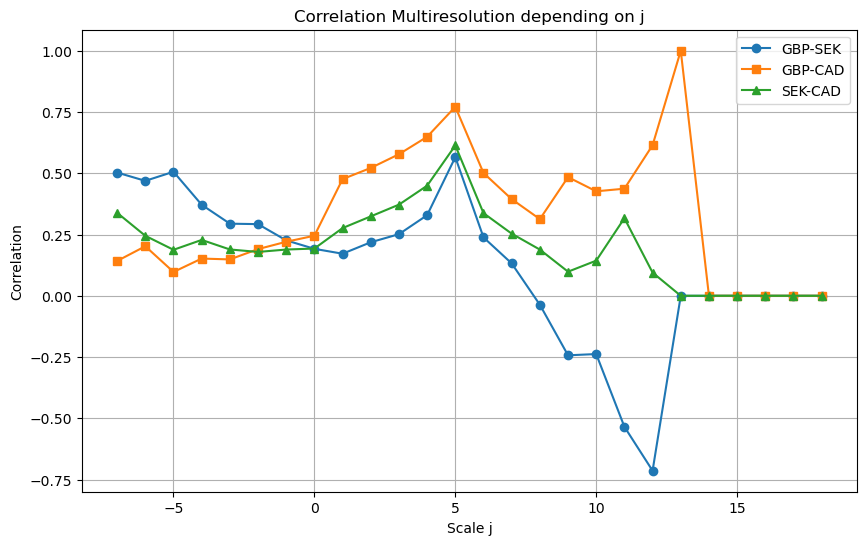

In [508]:
plt.figure(figsize=(10, 6))

plt.plot(axe_j, corr_gbp_sek_list, marker='o', label='GBP-SEK')
plt.plot(axe_j, corr_gbp_cad_list, marker='s', label='GBP-CAD')
plt.plot(axe_j, corr_sek_cad_list, marker='^', label='SEK-CAD')

plt.title("Correlation Multiresolution depending on j")
plt.xlabel("Scale j")
plt.ylabel("Correlation")
plt.legend()
plt.grid(True)

plt.show()

## Hurst exponent H ##

In [202]:
#we get the log of the price that is called X
for df in [df_gbp, df_sek, df_cad]:
    df['X'] = np.log(df['z(t)'])

df_gbp.head()

,Date,HIGH,LOW,t,k,z(t),returns,X
0,2016-03-07 08:59:59.990,1.2932,1.2917,0,-1,1.29245,NaN,0.256540
1,2016-03-07 09:15:00.000,1.2940,1.2930,1,0,1.29350,0.000812,0.257352
2,2016-03-07 09:30:00.000,1.2943,1.2922,2,1,1.29325,-0.000193,0.257158
3,2016-03-07 09:45:00.000,1.2930,1.2913,3,2,1.29215,-0.000851,0.256307
4,2016-03-07 10:00:00.000,1.2931,1.2921,4,3,1.29260,0.000348,0.256656


In [332]:
#we calculate the variance at lag 1
M2_gbp=0
n_gbp=len(df_gbp)
#in the loop we sum the values from fisrt to last of the dataset 
#(starting at 1 because we take return of the log prices, and for this we do current value - previous value) 
#and then we square it and divivde by the lenght (same lenght than the sum)
for i in range (1, n_gbp):
    M2_gbp=M2_gbp+(df_gbp["X"].iloc[i] - df_gbp["X"].iloc[i-1])**2
M2_gbp=M2_gbp*(1/n_gbp)

In [333]:
print(M2_gbp)

3.8899736801539624e-07


In [334]:
#we calculate the variance at lag 2 now
M2_gbp_prime=0
#in the loop we sum the values from fisrt to last of the dataset but this time with a time step of 2 so we do current value - the value of 2 iteration 
#(so previous of previous value)
#and then we square it and divivde by the lenght (same lenght than the sum) which this time is n/2 because we have a step of 2
for i in range (2, n_gbp, 2):
    M2_gbp_prime = M2_gbp_prime + (df_gbp["X"].iloc[i] - df_gbp["X"].iloc[i-2])**2
M2_gbp_prime=M2_gbp_prime*(2/n_gbp)

In [336]:
print(M2_gbp_prime)

9.875192246954796e-07


In [338]:
# M2_prime = (2lag)^2H and M2 = lag^2H
#M2_prime / M2 = (2*lag / lag)^(2H) = 2^(2H) so we have H=1/2 * log_base2 (M2_prime/M2)
H_gbp=(1/2)*math.log2(M2_gbp_prime/M2_gbp)

In [342]:
print(H_gbp)

0.6720242202463704


In [344]:
#we calculate the variance at lag 1
M2_sek=0
n_sek=len(df_sek)
#in the loop we sum the values from fisrt to last of the dataset 
#(starting at 1 because we take return of the log prices, and for this we do current value - previous value) 
#and then we square it and divivde by the lenght (same lenght than the sum)
for i in range (1, n_sek):
    M2_sek=M2_sek+(df_sek["X"].iloc[i] - df_sek["X"].iloc[i-1])**2
M2_sek=M2_sek*(1/n_sek)

In [345]:
#we calculate the variance at lag 2 now
M2_sek_prime=0
#in the loop we sum the values from fisrt to last of the dataset but this time with a time step of 2 so we do current value - the value of 2 iteration 
#(so previous of previous value)
#and then we square it and divivde by the lenght (same lenght than the sum) which this time is n/2 because we have a step of 2
for i in range (2, n_sek, 2):
    M2_sek_prime = M2_sek_prime + (df_sek["X"].iloc[i] - df_sek["X"].iloc[i-2])**2
M2_sek_prime=M2_sek_prime*(2/n_sek)

In [346]:
# M2_prime = (2lag)^2H and M2 = lag^2H
#M2_prime / M2 = (2*lag / lag)^(2H) = 2^(2H) so we have H=1/2 * log_base2 (M2_prime/M2)
H_sek=(1/2)*math.log2(M2_sek_prime/M2_sek)

In [348]:
print(H_sek)

0.6538170311483457


In [352]:
#we calculate the variance at lag 1
M2_cad=0
n_cad=len(df_cad)
#in the loop we sum the values from fisrt to last of the dataset 
#(starting at 1 because we take return of the log prices, and for this we do current value - previous value) 
#and then we square it and divivde by the lenght (same lenght than the sum)
for i in range (1, n_cad):
    M2_cad=M2_cad+(df_cad["X"].iloc[i] - df_cad["X"].iloc[i-1])**2
M2_cad=M2_cad*(1/n_cad)

In [353]:
#we calculate the variance at lag 2 now
M2_cad_prime=0
n=len(df_cad)
#in the loop we sum the values from fisrt to last of the dataset but this time with a time step of 2 so we do current value - the value of 2 iteration 
#(so previous of previous value)
#and then we square it and divivde by the lenght (same lenght than the sum) which this time is n/2 because we have a step of 2
for i in range (2, n_cad, 2):
    M2_cad_prime = M2_cad_prime + np.abs(df_cad["X"].iloc[i] - df_cad["X"].iloc[i-2])**2
M2_cad_prime=M2_cad_prime*(2/n_cad)

In [355]:
# M2_prime = (2lag)^2H and M2 = lag^2H
#M2_prime / M2 = (2*lag / lag)^(2H) = 2^(2H) so we have H=1/2 * log_base2 (M2_prime/M2)
H_cad=(1/2)*math.log2(M2_cad_prime/M2_cad)

In [358]:
print(H_cad)

0.6549201498228575


In [360]:
df_gbp["Date"] = pd.to_datetime(df_gbp["Date"])
df_sek["Date"] = pd.to_datetime(df_sek["Date"])
df_cad["Date"] = pd.to_datetime(df_cad["Date"])

df_gbp.set_index("Date", inplace=True)
df_sek.set_index("Date", inplace=True)
df_cad.set_index("Date", inplace=True)
df_gbp.head()

,HIGH,LOW,t,k,z(t),returns,X
Date,,,,,,,
2016-03-07 08:59:59.990,1.2932,1.2917,0,-1,1.29245,NaN,0.256540
2016-03-07 09:15:00.000,1.2940,1.2930,1,0,1.29350,0.000812,0.257352
2016-03-07 09:30:00.000,1.2943,1.2922,2,1,1.29325,-0.000193,0.257158
2016-03-07 09:45:00.000,1.2930,1.2913,3,2,1.29215,-0.000851,0.256307
2016-03-07 10:00:00.000,1.2931,1.2921,4,3,1.29260,0.000348,0.256656


In [476]:
#the returns are given for every 15 minutes meanwhile we want to have daily retuns
#resampl("D").last() take the last price of each day which is the closing price
daily_prices_gbp = df_gbp["X"].resample('D').last().dropna()
#then we calculate the daily log returns using the closing price of each day
daily_log_returns_gbp = np.log(daily_prices_gbp / daily_prices_gbp.shift(1)).dropna()

#we calculate the std using the formula std = sqrt((n/n-1)(E[X²]-E[X]²)
n = len(daily_log_returns_gbp)
#this is the E[X]
mean_ret = sum(daily_log_returns_gbp) / n
# this is the Sum of Squared Differences
sum_sq_diff = sum((r - mean_ret)**2 for r in daily_log_returns_gbp)
# Divide by n-1
variance = sum_sq_diff / (n - 1)
# Finally take the sqrt for the Standard Deviation
daily_vol_gbp = (variance)**(1/2)

#we calculate the annual volatility using the hurst exponent so it is daily volatility multiply by the number of trading days (252) power hurst exponent
annual_vol_hurst_gbp = daily_vol_gbp * (252 ** H_gbp)
#we calculate the classic annual volatility, using daily volatility multiply by the number of trading days (252) power 1/2 (so square root)
annual_vol_std_gbp = daily_vol_gbp * (252)**(1/2)

In [478]:
print("the annual volatility of gbp using Hurst exponent is : ",annual_vol_hurst_gbp)

the annual volatility of gbp using Hurst exponent is :  1.4807705589786666


In [480]:
print("the annual volatility of gbp using the std is : ",annual_vol_std_gbp)

the annual volatility of gbp using the std is :  0.5719903679786457


In [482]:
#the returns are given for every 15 minutes meanwhile we want to have daily retuns
#resampl("D").last() take the last price of each day which is the closing price
daily_prices_sek = df_sek["X"].resample('D').last().dropna()
#then we calculate the daily log returns using the closing price of each day
daily_log_returns_sek = np.log(daily_prices_sek / daily_prices_sek.shift(1)).dropna()

#we calculate the std using the formula std = sqrt((n/n-1)(E[X²]-E[X]²)
n = len(daily_log_returns_sek)
#this is the E[X]
mean_ret = sum(daily_log_returns_sek) / n
# this is the Sum of Squared Differences
sum_sq_diff = sum((r - mean_ret)**2 for r in daily_log_returns_sek)
# Divide by n-1
variance = sum_sq_diff / (n - 1)
# Finally take the sqrt for the Standard Deviation
daily_vol_sek = (variance)**(1/2)

#we calculate the annual volatility using the hurst exponent so it is daily volatility multiply by the number of trading days (252) power hurst exponent
annual_vol_hurst_sek = daily_vol_sek * (252 ** H_sek)
#we calculate the classic annual volatility, using daily volatility multiply by the number of trading days (252) power 1/2 (so square root)
annual_vol_std_sek = daily_vol_sek * 252**(1/2)

In [484]:
print("the annual volatility of sek using Hurst exponent is : ",annual_vol_hurst_sek)

the annual volatility of sek using Hurst exponent is :  0.050083122931325844


In [486]:
print("the annual volatility of sek using the std is : ",annual_vol_std_sek)

the annual volatility of sek using the std is :  0.02139513837570949


In [488]:
#the returns are given for every 15 minutes meanwhile we want to have daily retuns
#resampl("D").last() take the last price of each day which is the closing price
daily_prices_cad = df_cad["X"].resample('D').last().dropna()
#then we calculate the daily log returns using the closing price of each day
daily_log_returns_cad = np.log(daily_prices_cad / daily_prices_cad.shift(1)).dropna()

#we calculate the std using the formula std = sqrt((n/n-1)(E[X²]-E[X]²)
n = len(daily_log_returns_cad)
#this is the E[X]
mean_ret = sum(daily_log_returns_cad) / n
# this is the Sum of Squared Differences
sum_sq_diff = sum((r - mean_ret)**2 for r in daily_log_returns_cad)
# Divide by n-1
variance = sum_sq_diff / (n - 1)
# Finally take the sqrt for the Standard Deviation
daily_vol_sek = (variance)**(1/2)

#we calculate the annual volatility using the hurst exponent so it is daily volatility multiply by the number of trading days (252) power hurst exponent
annual_vol_hurst_cad = daily_vol_cad * (252 ** H_cad)
#we calculate the classic annual volatility, using daily volatility multiply by the number of trading days (252) power 1/2 (so square root)
annual_vol_std_cad = daily_vol_cad * 252**(1/2)

In [490]:
print("the annual volatility of cad using Hurst exponent is : ",annual_vol_hurst_cad)

the annual volatility of cad using Hurst exponent is :  0.5099232296337406


In [492]:
print("the annual volatility of cad using the std is : ",annual_vol_std_cad)

the annual volatility of cad using the std is :  0.2165107503888522
